### Homework: going neural (20 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
Download the data.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [9]:
!tar -xvzf arxivData.json.tar.gz

x arxivData.json


In [10]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [11]:

tokens = sorted(set("".join(lines)) | {BOS, EOS})
n_tokens = len(tokens)

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with its index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [12]:

token_to_id = {token: idx for idx, token in enumerate(tokens)}
print(token_to_id)


{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ':': 27, ';': 28, '<': 29, '=': 30, '>': 31, '?': 32, '@': 33, 'A': 34, 'B': 35, 'C': 36, 'D': 37, 'E': 38, 'F': 39, 'G': 40, 'H': 41, 'I': 42, 'J': 43, 'K': 44, 'L': 45, 'M': 46, 'N': 47, 'O': 48, 'P': 49, 'Q': 50, 'R': 51, 'S': 52, 'T': 53, 'U': 54, 'V': 55, 'W': 56, 'X': 57, 'Y': 58, 'Z': 59, '[': 60, '\\': 61, ']': 62, '^': 63, '_': 64, '`': 65, 'a': 66, 'b': 67, 'c': 68, 'd': 69, 'e': 70, 'f': 71, 'g': 72, 'h': 73, 'i': 74, 'j': 75, 'k': 76, 'l': 77, 'm': 78, 'n': 79, 'o': 80, 'p': 81, 'q': 82, 'r': 83, 's': 84, 't': 85, 'u': 86, 'v': 87, 'w': 88, 'x': 89, 'y': 90, 'z': 91, '{': 92, '|': 93, '}': 94, '~': 95, '\x7f': 96, '°': 97, 'É': 98, 'Ö': 99, 'Ü': 100, 'à': 101, 'á': 102, 'â': 103, 'ã': 104, 'ä': 105, 'æ': 106, 'ç': 107, 'è': 108, 'é': 109, 'ê':

In [13]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integer matrix with shape `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra `"EOS"` tokens or cropping long sequences. Here's how it works:

In [14]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [15]:
#Example: cast 4 random names to a single matrix, pad with zeros where needed.
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model (6 points including training)

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.pad = nn.ZeroPad2d((4, 0, 0, 0))  
        self.conv = nn.Conv1d(in_channels=emb_size, out_channels=hid_size, kernel_size=5)
        self.fc = nn.Linear(hid_size, n_tokens)

    def __call__(self, input_ix):
        x = self.emb(input_ix)
        x = x.permute(0, 2, 1)
        x = self.pad(x)  
        x = self.conv(x)  
        x = x.permute(0, 2, 1)
        logits = self.fc(x) 
        return logits

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            logits = self.__call__(prefix_ix)[0, -1]  
            probs = torch.softmax(logits / temperature, dim=-1).cpu().numpy() 
        return dict(zip(tokens, probs))


In [18]:
n_tokens = 136
dummy_model = FixedWindowLanguageModel(n_tokens=n_tokens)
dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)
print("Weights:", tuple((name, w) for name, w in dummy_model.named_parameters()))

Weights: (('emb.weight', Parameter containing:
tensor([[-0.0240, -1.0993,  0.1615,  ...,  0.1557,  0.8936,  1.8368],
        [ 1.6783, -1.4227,  1.0485,  ..., -0.0290,  1.0666,  0.1127],
        [-0.3138, -0.4533,  0.0163,  ..., -0.3833, -0.7158, -0.4749],
        ...,
        [ 0.2807, -0.4542, -0.3820,  ...,  0.5855, -0.4627, -0.1527],
        [-1.7710,  0.4188, -1.0808,  ..., -0.2809,  1.2485, -1.1911],
        [ 0.5256, -0.4775, -1.5245,  ..., -1.7372, -0.3133, -0.4838]],
       requires_grad=True)), ('conv.weight', Parameter containing:
tensor([[[ 0.0648,  0.0302,  0.0519, -0.0494,  0.0203],
         [-0.0862, -0.0223, -0.0383,  0.1068,  0.1101],
         [-0.0437,  0.0471,  0.0028, -0.0445,  0.0474],
         ...,
         [ 0.0791, -0.0496, -0.0656, -0.0514,  0.0850],
         [ 0.0715,  0.0744,  0.0926,  0.0079, -0.1024],
         [ 0.0635, -0.1080,  0.0583, -0.0916,  0.1109]],

        [[-0.0296, -0.0715, -0.0681, -0.0050,  0.1004],
         [ 0.0653, -0.0821, -0.0746,  0.0787

In [19]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (
    len(dummy_lines),
    max(map(len, dummy_lines)),
    n_tokens,
), f"Output shape mismatch: got {dummy_logits.shape}, expected {(len(dummy_lines), max(map(len, dummy_lines)), n_tokens)}"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax"


In [20]:

dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [21]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [22]:
def compute_loss(model, input_ix):
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64)  
    logits = model(input_ix[:, :-1])  
    reference_answers = input_ix[:, 1:]  
    mask = compute_mask(reference_answers)  

    # Вычисляем логарифмы вероятностей
    log_probs = F.log_softmax(logits, dim=-1)
    log_probs_flat = log_probs.view(-1, log_probs.shape[-1])  
    reference_answers_flat = reference_answers.view(-1) 
    mask_flat = mask.view(-1) 
    loss = F.nll_loss(
        log_probs_flat[mask_flat],  
        reference_answers_flat[mask_flat],  
        reduction='mean'  
    )
    
    return loss


In [23]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [24]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [25]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel()
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridging|=1X"9[~#$ś$@ωfJÖSGG4:CõlgíÉ|ãRi>=$ärç5z>m{ω7äy_jv3αo#ã:γA]]8/xrf|iVλεTi:/náQő d|



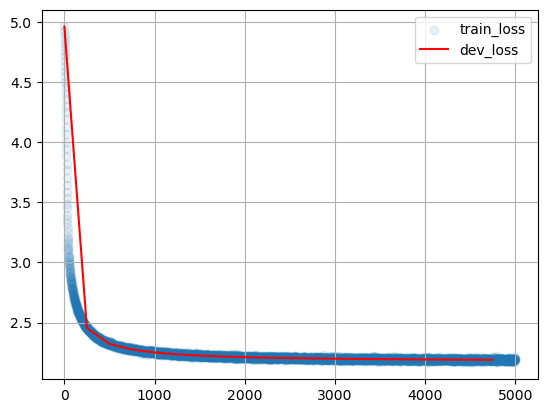

Generated examples (tau=0.5):
 Le riske botid ts andure thes she mation fion mone thare the terentrof ame ther propestr and destio 
 Sofal ariont makn model naction the s Opestive tore ffre the engen the ser and of emangon bation ; I
 Ant anting ing se chmod and inge p Learel and of ame tor chare se the simalizition al bised be work 
Scoring dev...


100%|███████████████████████████████████████| 5000/5000 [30:59<00:00,  2.69it/s]

#4999 Dev loss: 2.190


In [98]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    
    loss_i = compute_loss(model, batch)
    
    opt.zero_grad()
    loss_i.backward()
    opt.step()
        
    train_history.append((i, loss_i.item()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [99]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 2.1898203352486214
 A Ancentint on whe roment onetr arcentwe co pres bes ase anded ne the serore For chas ba doraction i
 Seaplisica no phesention th In pron the poreancon se the sented fithe tha sent ane of am whio pare s
 Assins aperalized of entwor and ind and ion lateving comedelicitita duction the senton isith arilles
 Ancon ther porelenting ion the and exteres of conet on che on thas in alales (CNN) an suand sobjoct 
 In the peoppriticonstion the antection the and inat of ration ing ores se cor the tha probas der mon
 Aralen thes bate tor stom seat in as ans and ion latwork the merely ty for thed th e perver are the 
 De phes for ange sion and cens may on the serich ten com on as bol che on the seath explace probused
 Intrremantict al work tha n mont an robend ark of ar works with the ention ; We de cond corece tathe
 Ancancon taperon medsed on ancralization of concentition cos the the s of an withr ion and pontion s
 Crapornation are the s for the s and tha ponti

### RNN Language Models (10 points including training)

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [26]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, emb_size)
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=hid_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hid_size, n_tokens)

    def __call__(self, input_ix):
        x = self.emb(input_ix)  
        x, _ = self.lstm(x)  
        logits = self.fc(x) 
        return logits

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  
        return dict(zip(tokens, probs))

        

In [27]:
model = RNNLanguageModel()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print("Weights:", tuple((name, w) for name, w in dummy_model.named_parameters()))

Weights: (('emb.weight', Parameter containing:
tensor([[-0.0240, -1.0993,  0.1615,  ...,  0.1557,  0.8936,  1.8368],
        [ 1.6783, -1.4227,  1.0485,  ..., -0.0290,  1.0666,  0.1127],
        [-0.3138, -0.4533,  0.0163,  ..., -0.3833, -0.7158, -0.4749],
        ...,
        [ 0.2807, -0.4542, -0.3820,  ...,  0.5855, -0.4627, -0.1527],
        [-1.7710,  0.4188, -1.0808,  ..., -0.2809,  1.2485, -1.1911],
        [ 0.5256, -0.4775, -1.5245,  ..., -1.7372, -0.3133, -0.4838]],
       requires_grad=True)), ('conv.weight', Parameter containing:
tensor([[[ 0.0648,  0.0302,  0.0519, -0.0494,  0.0203],
         [-0.0862, -0.0223, -0.0383,  0.1068,  0.1101],
         [-0.0437,  0.0471,  0.0028, -0.0445,  0.0474],
         ...,
         [ 0.0791, -0.0496, -0.0656, -0.0514,  0.0850],
         [ 0.0715,  0.0744,  0.0926,  0.0079, -0.1024],
         [ 0.0635, -0.1080,  0.0583, -0.0916,  0.1109]],

        [[-0.0296, -0.0715, -0.0681, -0.0050,  0.1004],
         [ 0.0653, -0.0821, -0.0746,  0.0787

In [28]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [29]:
batch_size = 64         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []

model = RNNLanguageModel()
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridging0$}γAWBiRyFp"Łè5[εä\RaőIç)σ^dü( $odA>p°PDpśΩ



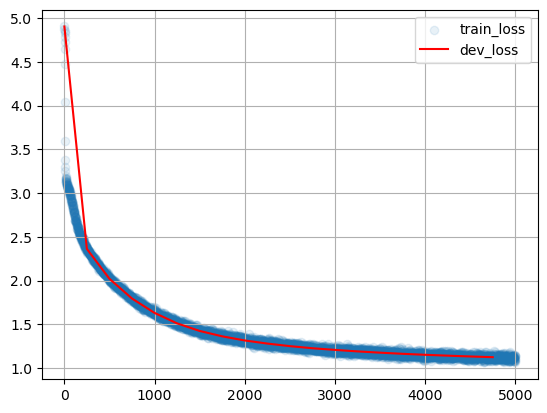

Generated examples (tau=0.5):
 Machine Search for Solution of Scale Text Complete Sparse Models ; Deep neural networks to inference
 A Self-organization of Semi-Supervised Learning ; In this paper, we propose a new human problems, an
 Recurrent Neural Networks for Bayesian Embedding ; We present a highly approach for the problem of t
Scoring dev...


100%|█████████████████████████████████████| 5000/5000 [1:00:47<00:00,  1.37it/s]

#4999 Dev loss: 1.119


In [30]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    loss_i = compute_loss(model, batch)
    opt.zero_grad()
    loss_i.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0) 
    opt.step()
    train_history.append((i, float(loss_i)))
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])

In [31]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 1.1190687097689
 Learning Multi-Analysis of Convolutional Neural Networks ; The method for long systems are constrain
 Self-Efficient Topics with Deep Real-time Approach for Selection ; Accurate model for the segmentati
 A Multi-Recognition and Evaluation for Segmentation ; The problem of exploiting memory selection bet
 A Complex Large Bayesian Models for Control Sensor Detection ; We present a simple framework for exp
 Market for Risk Semantic Problems ; In this paper we present a new classifier in a proper to the pro
 Semantic Entropy Problems and Resolution of Automatic Planning ; The object classifier is interpreta
 Simple Synthetic Level Reduction ; This paper presents a new standard problem of a set of optimal fo
 Indexing Solution for Classifiers ; The proposed translation of the literature in order to make the 
 Deep Learning and Resolution of Structure of Automatic Model for Learning ; The empirical results an
 Semantically Adversarial Networks ; In this paper

### Alternative sampling strategies (2 point)

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize: 
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleus sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleus N=0.9, the nucleus words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleus words, you need to re-normalize them as in top-k sampling and generate the next token.

__Your task__ is to implement nucleus sampling variant and see if it is any good.

In [32]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        sorted_indices = np.argsort(probs)[::-1]  
        sorted_probs = np.array(probs)[sorted_indices]
        sorted_tokens = np.array(tokens)[sorted_indices]
        cumulative_probs = np.cumsum(sorted_probs)
        nucleus_mask = cumulative_probs <= nucleus
        nucleus_mask[0] = True  
        nucleus_tokens = sorted_tokens[nucleus_mask]
        nucleus_probs = sorted_probs[nucleus_mask]
        nucleus_probs /= nucleus_probs.sum()
        next_token = np.random.choice(nucleus_tokens, p=nucleus_probs)
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: 
            break
    
    return prefix

In [34]:
for i in range(10):
     print(generate_nucleus(model, nucleus=0.95))

 Improvement of a testing mathematical space of algorithm for   method is a proven table an image new
 Using Douning Model Convolutional Neural Media for Study ; Efficient transcribuation of learning for
 Eatelly Challenging Astist and Complex Neural   Stage Magnetic Pregists Using Deep Learning ; Object
 Sparse Cardo on Bayesian Patient Detection and Interpretable End-to-Pargur A Generative Sparse Analy
 Classification projeinning in version via the the algorithm of training data for general challenges 
 Diversity for Multi-Deep Clusters of Optimization ; In this paper, we propose in the approximation o
 How the Elements for Large Method for Learning System ; Each traditional models with which can be us
 Recently Adaptation for Information the Task   Real-time Local   Vision Based ; Each inspired on a m
 To Neural Networks for Intelligence ; Archised asymmetric sparse regression and in based on scale li
 Discapes and an Acoust Of Present Learning ; We present the present and multiple 

In [35]:
for i in range(10):
     print(generate_nucleus(model, nucleus=0.55))

 Deep Residual Networks for Interpretable Analysis ; The state of the interaction and interactions of
 Deep Learning of Learning with Statistical   Segmentation ; In this paper, we propose a new approach
 The Distribution of Statistical Models for Prediction ; In this paper, we propose a new problem of a
 Exploiting Multi-State Problems for Automatic Research ; In this paper, we propose a new data for en
 Learning with Adaptive Search in   Interaction of Interpretable ; The experimental regression method
 A Bayesian networks for deep learning and the detection ; The problem of a machine learning to encod
 Learning and Statistical Semantic Programming for Markov Regression ; In this paper, we propose a ne
 A Convolutional Neural Networks for Action Method for Statistical   Problem ; The problem of semanti
 Statistical Learning and Active Convolutional Neural Networks ; We present a new data in a semantic 
 Statistical Model of Semantic Regression ; The problem of a simple constraint and

In [36]:
for i in range(10):
     print(generate_nucleus(model, nucleus=0.99))

 Describefia Predictors: Out Data Plang ; We present a problems with item interactions from science t
 Semantic Rotating or Two-Pot and While a Deep Neural Networks ; Using Residual Interval components a
 A Deep Learning ; Various search and image in the type classification of entity models with neural m
 Database Active   Consider Space and Classification Brain Equation Approach lows ; Deep various colo
 Multi-Generative Resolutions of Ligi-Ort and Vitries Single   Learning with Deep Neural   Camera Exo
 Sentences and learning of the evaluate nonlinear application ; We address the key is crossline class
 Real-Based Fourx With Computing Multisligh Chinds ; Algorithm is an igseling, has inteligent only ex
 Bolable Compositional Artificial Practical Feature Pierative   Sparsi ; Conjinuoulies matimising are
 Fusion Techniques of with Annotating for This Quadradity face Complexity ; We present a natural cons
 A Comporlation Restation of Selvers for Uplan Information ; Visual   deep underst

### Beam Search (2 pts incl. samples)

At times, you don't really want the model to generate diverse outputs as much as you want a __single most likely hypothesis.__ A single best translation, most likely continuation of the search query given prefix, etc. Except, you can't get it. 

In order to find the exact most likely sequence containing 10 tokens, you would need to enumerate all $|V|^{10}$ possible hypotheses. In practice, 9 times out of 10 you will instead find an approximate most likely output using __beam search__.

Here's how it works:
0. Initial `beam` = [prefix], max beam_size = k
1. for T steps:
2. ` ... ` generate all possible next tokens for all hypotheses in beam, formulate `len(beam) * len(vocab)` candidates
3. ` ... ` select beam_size best for all candidates as new `beam`
4. Select best hypothesis (-es?) from beam

In [37]:
from IPython.display import HTML
# Here's what it looks like:
!wget -q https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/resources/beam_search.html
HTML("beam_search.html")

zsh:1: command not found: wget


In [38]:
def generate_beamsearch(model, prefix=BOS, beam_size=4, length=5):
    beam = [(prefix, 0.0)]  
    for _ in range(length):
        all_candidates = []
        
        for seq, log_prob in beam:
            token_probs = model.get_possible_next_tokens(seq)
            tokens, probs = zip(*token_probs.items())
            log_probs = np.log(probs)  
            for token, log_p in zip(tokens, log_probs):
                new_seq = seq + token
                new_log_prob = log_prob + log_p
                all_candidates.append((new_seq, new_log_prob))
        all_candidates = sorted(all_candidates, key=lambda x: x[1], reverse=True)  
        beam = all_candidates[:beam_size]  
    return beam


In [39]:
generate_beamsearch(model, prefix=' deep ', beam_size=4)

[(' deep learn', -2.603086717426777),
 (' deep Learn', -2.794778657145798),
 (' deep Convo', -4.606813907623291),
 (' deep Resol', -5.721109073609114)]

In [2]:
# check it out: which beam size works best?
# find at least 5 prefixes where beam_size=1 and 8 generates different sequences

In [40]:
prefixes = [' deep ', ' learning ', ' artificial ', ' natural ', ' language ']
for prefix in prefixes:
    print(f"Prefix: {prefix}")
    print("Beam size = 1:", generate_beamsearch(model, prefix=prefix, beam_size=1, length=5))
    print("Beam size = 8:", generate_beamsearch(model, prefix=prefix, beam_size=8, length=5))
    print("-" * 30)

Prefix:  deep 
Beam size = 1: [(' deep Learn', -2.794778657145798)]
Beam size = 8: [(' deep learn', -2.603086717426777), (' deep Learn', -2.794778657145798), (' deep Neura', -3.7810460217297077), (' deep Convo', -4.606813907623291), (' deep level', -5.114699512720108), (' deep Resol', -5.721109073609114), (' deep lever', -6.063628375530243), (' deep Conve', -6.191857725381851)]
------------------------------
Prefix:  learning 
Beam size = 1: [(' learning and t', -5.012146866880357)]
Beam size = 8: [(' learning algor', -3.6842908612452447), (' learning with ', -3.749668779782951), (' learning of th', -4.93508118391037), (' learning in th', -4.973548278212547), (' learning and t', -5.012146866880357), (' learning that ', -5.042885273694992), (' learning and a', -5.263251221738756), (' learning and s', -5.266310608945787)]
------------------------------
Prefix:  artificial 
Beam size = 1: [(' artificial Analy', -5.048669010400772)]
Beam size = 8: [(' artificial Learn', -3.1896857148967683